# Creating Pyramid Model for Multi-Scale Quadrat Density Maps

### The following code creates random and clustered point sets and store the multi-scale quadrat density maps in the Pyramid Model

---

#### Import necessary packages

In [1]:
import seaborn as sns
import pandas as pd
import geopandas as gpd
import time
import numpy as np
import random 
import scipy.io as sio
from scipy import stats
import scipy
from mpl_toolkits.mplot3d import Axes3D
from scipy import spatial
from findpeaks import findpeaks
import math
import kde_pyramid

import matplotlib.pyplot as plt
plt.ion() # turn on interactive plotting
plt.rcParams['figure.figsize'] = [10, 10] # enlarge the default plotting size

from pyproj import Proj

import os
# You need to replace the path with the folder of Anaconda in your computer
os.environ['PROJ_LIB'] = 'C:/ProgramData/Anaconda3/Library/share/'

#from mpl_toolkits.basemap import Basemap

%matplotlib inline

from geopandas import GeoSeries
from shapely.geometry import Polygon

import pysal
from pysal.explore.pointpats import poly_from_bbox, PointPattern
from pointpats import Window
import contextily
from pointpats import distance_statistics,QStatistic, random, PointPattern
#import quadrat_statistics_rev


import PointProcess
#from PointProcess import PoissonPointProcess, PoissonClusterPointProcess
import libpysal as ps
from libpysal.cg import shapely_ext

from sklearn.neighbors import KernelDensity

import plotly.graph_objects as go

C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\geo\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(


## 1. Create the study area

In [2]:
path="E:/Projects/Pyramid_model/GIS_data/"

w = 500
buff = 0
Xmin,Xmax,Ymin,Ymax=[-buff,w+buff,-buff,w+buff]
p1 = Polygon([(Xmin, Ymin), (Xmax,Ymin), (Xmax, Ymax),(Xmin,Ymax)])

#p1 = Polygon([(483214, 4425818), (489214, 4425818), (489214, 4431818),(483214,4431818)])
g = GeoSeries(p1)

df_st = pd.DataFrame({'name': ["square area"],'size': [str(w)]})
gdf_st = gpd.GeoDataFrame(df_st, geometry=g)

gdf_st.to_file(path+"square_study_area.shp")

## 2. Load the study area as the window for creating point set### Load the study area

In [3]:
# open the Philadelphia polygon shapefile
sqr = ps.io.open("E:/Projects/Pyramid_model/GIS_data/square_study_area.shp")
sqr = [shp for shp in sqr]

sqr = shapely_ext.cascaded_union(sqr)
# create window from virginia state boundary
window = Window(sqr.parts)

## 3. Create multiple cluster point sets with varying radius and parent nodes### Simulating a clustered pattern

# of points:500, # of parent nodes:1
# of points:700, # of parent nodes:7
Total # of random points:823
Total # of points:1866, # of parent nodes:8


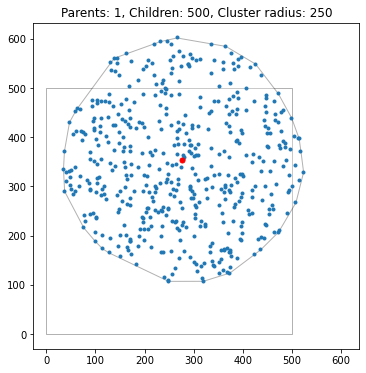

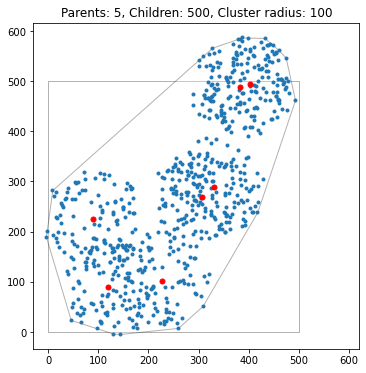

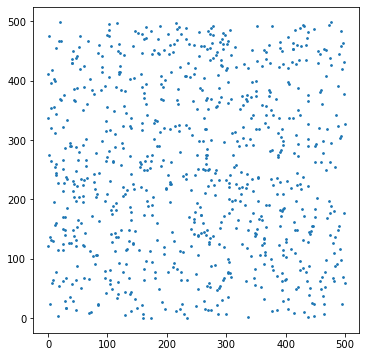

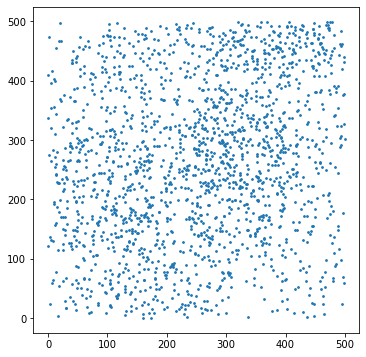

In [5]:
np.random.seed(3)

# p_ls =[1,5,10,15] # number of parents
# n_ls = [500,500,500,500] # size of each realization
# r_ls=[250,150, 100, 50] # radius around parents
# c_ls=[False,True, True, True] # CRS conditioning

p_ls =[1,5] # number of parents
n_ls = [500,500] # size of each realization
r_ls=[250,100] # radius around parents
c_ls=[False,True] # CRS conditioning



pnt_df = pd.DataFrame(columns=['x', 'y'])
parent_df = pd.DataFrame(columns=['x', 'y'])

n1=0
n2=0

for p,n,r,c in zip(p_ls,n_ls,r_ls, c_ls):

    #csamples = PointProcess.PoissonClusterPointProcess(window, 250, 5, 100, 1, asPP=True, conditioning=False)

    csamples = PointProcess.PoissonClusterPointProcess(window,  n,  p , r, 1, asPP=True, conditioning=c)

    pp_pcp = csamples.realizations[0]
    
    plt.rcParams["figure.figsize"]=(6, 6)
    pp_pcp.plot(window=True, hull=True, title='Parents: {}, Children: {}, Cluster radius: {}'.format(p, n, r)) #plot the first realization #use class method "plot" to visualize point pattern
    plt.plot(csamples.parentnodes.points.x,csamples.parentnodes.points.y, linestyle='None', marker='o', markersize = 5.0, color = 'r') 
    plt.axis('square')
    #     cents=csamples.cents
    #     x=cents[0][:,0]
    #     y=cents[0][:,1]
    #     plt.plot(x, y, 'ro')

    #     cents= pd.DataFrame({'x': cents[0][:, 0], 'y': cents[0][:, 1]})
    #     cent_ls.append(cents)
    #     cent_df=pd.concat([cent_df,cents])
    print('# of points:' +str(pp_pcp.points.shape[0]) + ', # of parent nodes:'+str(csamples.parentnodes.points.shape[0]) )
    pnt_df=pd.concat([pnt_df,pp_pcp.points])
    parent_df = pd.concat([parent_df,csamples.parentnodes.points])

    #     n1=n1+cents.count()
    n2=n2+pp_pcp.points.count()

num_p_origin = 2000 - pnt_df.shape[0]
for n in list(np.linspace(0,500,51)):
    num_p = num_p_origin+n
    samples = PointProcess.PoissonPointProcess(window, num_p, 1, conditioning=True, asPP=False)
    pp_csr = PointPattern(samples.realizations[0])
    pp_ran = pp_csr.points
    pp_ran = pp_ran[(pp_ran['x']>=Xmin)&(pp_ran['x']<=Xmax)&(pp_ran['y']>=Ymin)&(pp_ran['y']<=Ymax)]
    if pp_ran.shape[0]>num_p_origin:
        break

fig = plt.figure(3, figsize=(9, 6))
plt.scatter(pp_ran['x'], pp_ran['y'],s=3)
plt.axis('square')
print('Total # of random points:' +str(pp_ran.shape[0]))

# combine clustered pattern and random pattern
pnt_df=pd.concat([pnt_df,pp_ran])

## Exclude points in buffer
pnt_df = pnt_df[(pnt_df['x']>=Xmin)&(pnt_df['x']<=Xmax)&(pnt_df['y']>=Ymin)&(pnt_df['y']<=Ymax)]

fig = plt.figure(4, figsize=(9, 6))
plt.scatter(pnt_df['x'], pnt_df['y'],s=3)
plt.axis('square')

print('Total # of points:' +str(pnt_df.shape[0]) + ', # of parent nodes:'+str(parent_df.shape[0]) )

## 4. Combine the points sets into one and create a random point set

# of clustered points: 1837
# of random points: 1837


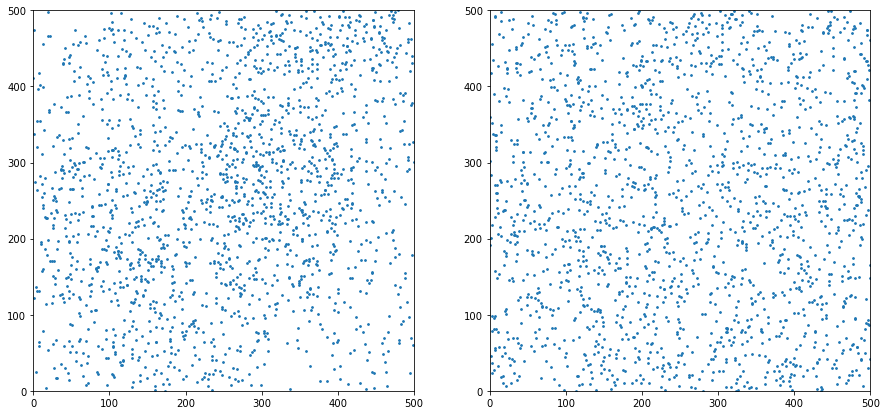

In [6]:
# ----------------- plot multi-level clustered points ----------------------------

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 15)

ax1.scatter(pnt_df['x'], pnt_df['y'],s=3)
ax1.axis('square')
ax1.set_xlim(0,w)
ax1.set_ylim(0,w)


# ------------------ plot random points in the same number -------------------
# simulate a csr process in the same window (1000 points, 1 realization)
# by specifying "asPP" false, we can generate a point series
# by specifying "conditioning" false, we can simulate a N-conditioned CSR
np.random.seed(10)

num_p_origin = pnt_df.shape[0]
for n in list(np.linspace(0,1000,50).astype(int)):
    num_p = pnt_df.shape[0]-1000+n
    samples = PointProcess.PoissonPointProcess(window, num_p, 1, conditioning=True, asPP=False)
    pp_csr = PointPattern(samples.realizations[0])
    pp_ran = pp_csr.points
    pp_ran = pp_ran[(pp_ran['x']>=Xmin)&(pp_ran['x']<=Xmax)&(pp_ran['y']>=Ymin)&(pp_ran['y']<=Ymax)]
    if pp_ran.shape[0]>num_p_origin:
        break


# Select the same number of points as the clustered pattern
pp_ran = pp_ran[0:pnt_df.shape[0]]

# pp_csr = samples.realizations[0] # if a λ conditioned CSR
print('# of clustered points: '+str(pp_ran.shape[0]))
print('# of random points: '+str(pp_ran.shape[0]))
# plot using PointPattern inherent function
#pp_csr.plot(window=True, hull=False, title='Random Point Pattern')

ax2.scatter(pp_ran['x'], pp_ran['y'],s=3)
ax2.axis('square')
ax2.set_xlim(0,w)
ax2.set_ylim(0,w)

# Save the points to CSV files

pnt_df.to_csv('E:/Projects/Pyramid_model/tables/sim_pnts_cluster.csv')
pp_ran.to_csv('E:/Projects/Pyramid_model/tables/sim_pnts_random.csv')

## 5. Creating PM for Quadrat Density Maps of the Clustered Point Set

In [7]:
base = np.zeros(((Xmax-Xmin),(Ymax-Ymin)))

count_e = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
count_o = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
count_res = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
intensity = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))


import time
start = time.time()

for lv in range(0,int((Ymax-Ymin)/2)):
#for lv in range(0,10):
    start = time.time()


    z = lv+1 # scale, vertical level in PM starting from 0 at the base layer
    padding = z
    window = z*2+1
    num_window = ((Ymax-Ymin)*(Xmax-Xmin))/window**2
    
    e = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    e[:] = np.NaN

    o = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    o[:] = np.NaN
    
    res = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    res[:] = np.NaN
    
    i = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    i[:] = np.NaN
    
    for x in range(Xmin+padding,Xmax-padding):
        for y in range(Ymin+padding,Ymax-padding):
            slc_pnt = pnt_df[(pnt_df['x']>x-padding)&(pnt_df['y']>y-padding)&(pnt_df['x']<x+padding)&(pnt_df['y']<y+padding)]
            count = slc_pnt.shape[0]
            density = count/(window**2)
            i[y,x] = density
            e[y,x]=count
            est_count = pnt_df.shape[0]/num_window
            o[y,x]=est_count
            res[y,x]=(count-est_count)/np.sqrt(est_count)
    #         print('points: ' + str(count))
    #         print('area: '+str(area))
    #         print('density: '+str(count/area))

    intensity[:,:,lv]= np.flip(i,axis=0)
    count_e[:,:,lv]= np.flip(e,axis=0)
    count_o[:,:,lv]= np.flip(o,axis=0)
    count_res[:,:,lv]= np.flip(res,axis=0)
    
    end = time.time()
    time_elapsed =time.strftime("%H:%M:%S", time.gmtime(end-start))
    print(f"Time taken is for layer {lv} is {time_elapsed}")

end = time.time()
print(end - start)

Time taken is for layer 0 is 00:03:20
Time taken is for layer 1 is 00:03:12
Time taken is for layer 2 is 00:03:10
Time taken is for layer 3 is 00:03:16
Time taken is for layer 4 is 00:03:18
Time taken is for layer 5 is 00:03:15
Time taken is for layer 6 is 00:03:14
Time taken is for layer 7 is 00:03:13
Time taken is for layer 8 is 00:03:11
Time taken is for layer 9 is 00:03:10
Time taken is for layer 10 is 00:03:14
Time taken is for layer 11 is 00:03:10
Time taken is for layer 12 is 00:03:06
Time taken is for layer 13 is 00:03:05
Time taken is for layer 14 is 00:03:05
Time taken is for layer 15 is 00:03:03
Time taken is for layer 16 is 00:03:01
Time taken is for layer 17 is 00:03:01
Time taken is for layer 18 is 00:02:48
Time taken is for layer 19 is 00:02:49
Time taken is for layer 20 is 00:02:49
Time taken is for layer 21 is 00:02:45
Time taken is for layer 22 is 00:02:43
Time taken is for layer 23 is 00:02:43
Time taken is for layer 24 is 00:02:41
Time taken is for layer 25 is 00:02

Time taken is for layer 208 is 00:00:05
Time taken is for layer 209 is 00:00:05
Time taken is for layer 210 is 00:00:05
Time taken is for layer 211 is 00:00:05
Time taken is for layer 212 is 00:00:04
Time taken is for layer 213 is 00:00:04
Time taken is for layer 214 is 00:00:04
Time taken is for layer 215 is 00:00:03
Time taken is for layer 216 is 00:00:03
Time taken is for layer 217 is 00:00:03
Time taken is for layer 218 is 00:00:03
Time taken is for layer 219 is 00:00:02
Time taken is for layer 220 is 00:00:02
Time taken is for layer 221 is 00:00:02
Time taken is for layer 222 is 00:00:02
Time taken is for layer 223 is 00:00:02
Time taken is for layer 224 is 00:00:02
Time taken is for layer 225 is 00:00:01
Time taken is for layer 226 is 00:00:01
Time taken is for layer 227 is 00:00:01
Time taken is for layer 228 is 00:00:01
Time taken is for layer 229 is 00:00:01
Time taken is for layer 230 is 00:00:01
Time taken is for layer 231 is 00:00:01
Time taken is for layer 232 is 00:00:01


#### Plot a layer for testing

(0.0, 500.0)

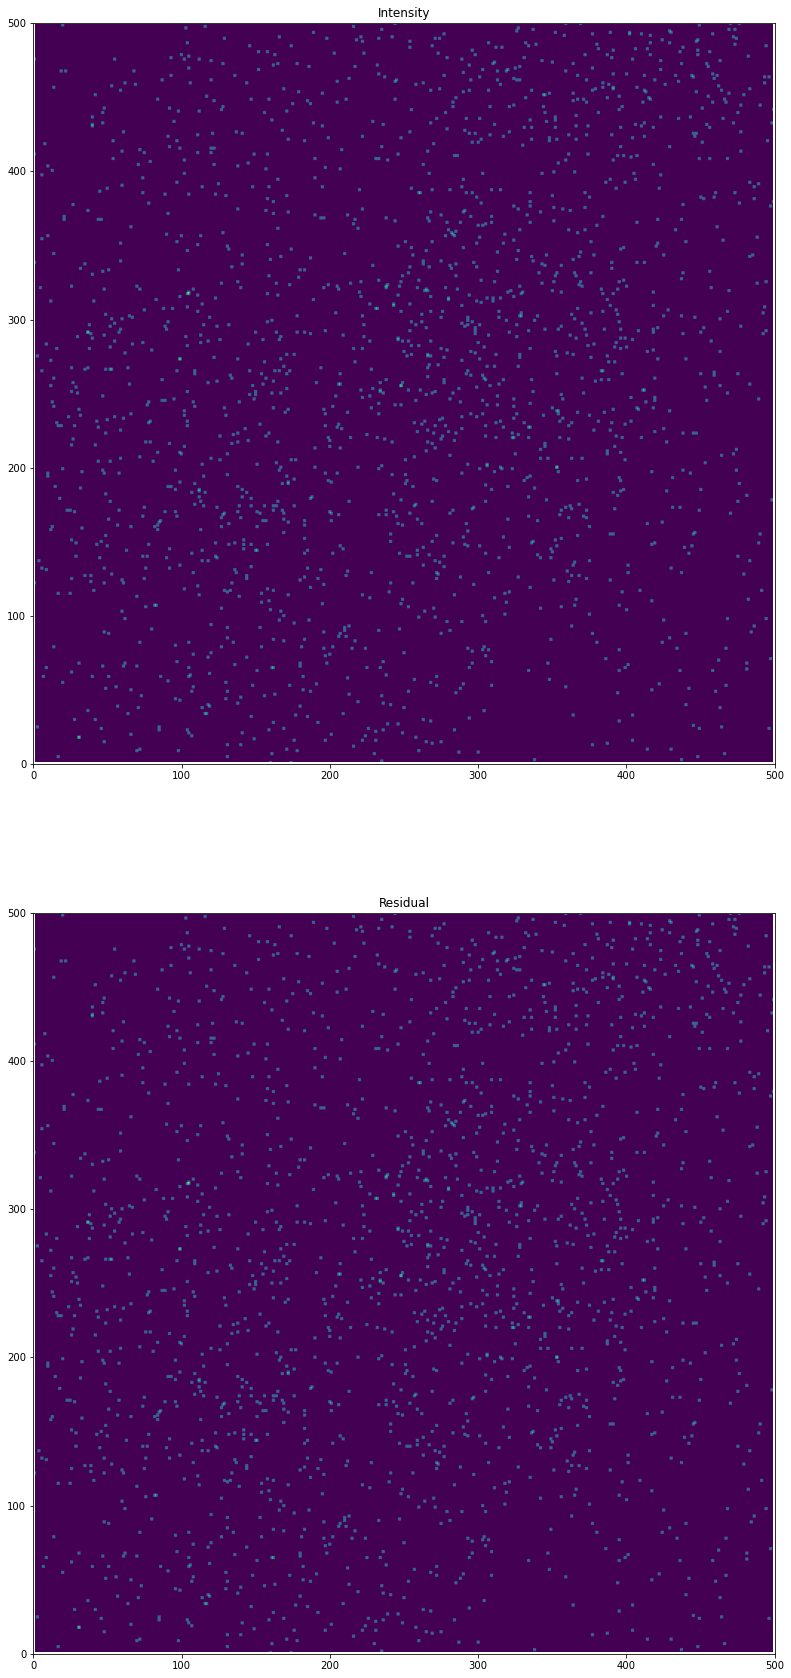

In [8]:
### plt.rcParams['figure.figsize'] = (30, 30)
lv = 0

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(30, 30)

Xlim = [0+lv,Xmax-lv]
Ylim = [0+lv,Ymax-lv]

ax1.imshow(intensity[:,:,lv], extent=[0,500,0,500])
ax1.title.set_text('Intensity')
ax1.set_xlim(Xlim[0],Xlim[1])
ax1.set_ylim(Ylim[0],Ylim[1])

ax2.imshow(count_res[:,:,lv], extent=[0,500,0,500])
ax2.title.set_text('Residual')
ax2.set_xlim(Xlim[0],Xlim[1])
ax2.set_ylim(Ylim[0],Ylim[1])

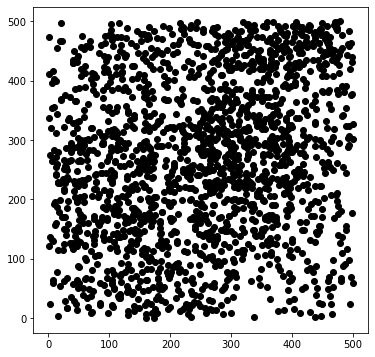

In [9]:
plt.plot(pnt_df['x'], pnt_df['y'], 'o', color='black');

## 6. Creating PM for Quadrat Density Maps of the Random Point Set

In [10]:
base = np.zeros(((Xmax-Xmin),(Ymax-Ymin)))

#count_e = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
#count_o = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
#count_res = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))
intensity_ran = np.zeros(((Xmax-Xmin),(Ymax-Ymin),int((Ymax-Ymin)/2)))


import time
start = time.time()

for lv in range(0,int((Ymax-Ymin)/2)):
#for lv in range(0,10):
    start = time.time()


    z = lv+1 # scale, vertical level in PM starting from 0 at the base layer
    padding = z
    window = z*2+1
    num_window = ((Ymax-Ymin)*(Xmax-Xmin))/window**2
    
    
    e = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    e[:] = np.NaN

    o = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    o[:] = np.NaN
    
    res = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    res[:] = np.NaN
    
    i = np.empty(((Xmax-Xmin),(Ymax-Ymin)))
    i[:] = np.NaN
    
    for x in range(Xmin+padding,Xmax-padding):
        for y in range(Ymin+padding,Ymax-padding):
            slc_pnt = pp_ran[(pp_ran['x']>x-padding)&(pp_ran['y']>y-padding)&(pp_ran['x']<x+padding)&(pp_ran['y']<y+padding)]
            count = slc_pnt.shape[0]
            density = count/(window**2)
            i[y,x] = density
            e[y,x]=count
            est_count = pp_ran.shape[0]/num_window
            o[y,x]=est_count
            res[y,x]=(count-est_count)/np.sqrt(est_count)

    intensity_ran[:,:,lv]= np.flip(i,axis=0)
    
    end = time.time()
    time_elapsed =time.strftime("%H:%M:%S", time.gmtime(end-start))
    print(f"Time taken is for layer {lv} is {time_elapsed}")

end = time.time()
print(end - start)

Time taken is for layer 0 is 00:03:18
Time taken is for layer 1 is 00:03:17
Time taken is for layer 2 is 00:03:16
Time taken is for layer 3 is 00:03:15
Time taken is for layer 4 is 00:03:11
Time taken is for layer 5 is 00:03:10
Time taken is for layer 6 is 00:03:11
Time taken is for layer 7 is 00:03:06
Time taken is for layer 8 is 00:03:06
Time taken is for layer 9 is 00:03:04
Time taken is for layer 10 is 00:03:04
Time taken is for layer 11 is 00:03:02
Time taken is for layer 12 is 00:03:00
Time taken is for layer 13 is 00:02:59
Time taken is for layer 14 is 00:02:56
Time taken is for layer 15 is 00:02:54
Time taken is for layer 16 is 00:02:54
Time taken is for layer 17 is 00:02:53
Time taken is for layer 18 is 00:02:52
Time taken is for layer 19 is 00:02:49
Time taken is for layer 20 is 00:02:51
Time taken is for layer 21 is 00:02:49
Time taken is for layer 22 is 00:02:46
Time taken is for layer 23 is 00:02:44
Time taken is for layer 24 is 00:02:44
Time taken is for layer 25 is 00:02

Time taken is for layer 208 is 00:00:05
Time taken is for layer 209 is 00:00:05
Time taken is for layer 210 is 00:00:05
Time taken is for layer 211 is 00:00:04
Time taken is for layer 212 is 00:00:04
Time taken is for layer 213 is 00:00:04
Time taken is for layer 214 is 00:00:04
Time taken is for layer 215 is 00:00:03
Time taken is for layer 216 is 00:00:03
Time taken is for layer 217 is 00:00:03
Time taken is for layer 218 is 00:00:03
Time taken is for layer 219 is 00:00:02
Time taken is for layer 220 is 00:00:02
Time taken is for layer 221 is 00:00:02
Time taken is for layer 222 is 00:00:02
Time taken is for layer 223 is 00:00:02
Time taken is for layer 224 is 00:00:02
Time taken is for layer 225 is 00:00:01
Time taken is for layer 226 is 00:00:01
Time taken is for layer 227 is 00:00:01
Time taken is for layer 228 is 00:00:01
Time taken is for layer 229 is 00:00:01
Time taken is for layer 230 is 00:00:01
Time taken is for layer 231 is 00:00:01
Time taken is for layer 232 is 00:00:00


#### Plot a layer for testing

(0.0, 500.0)

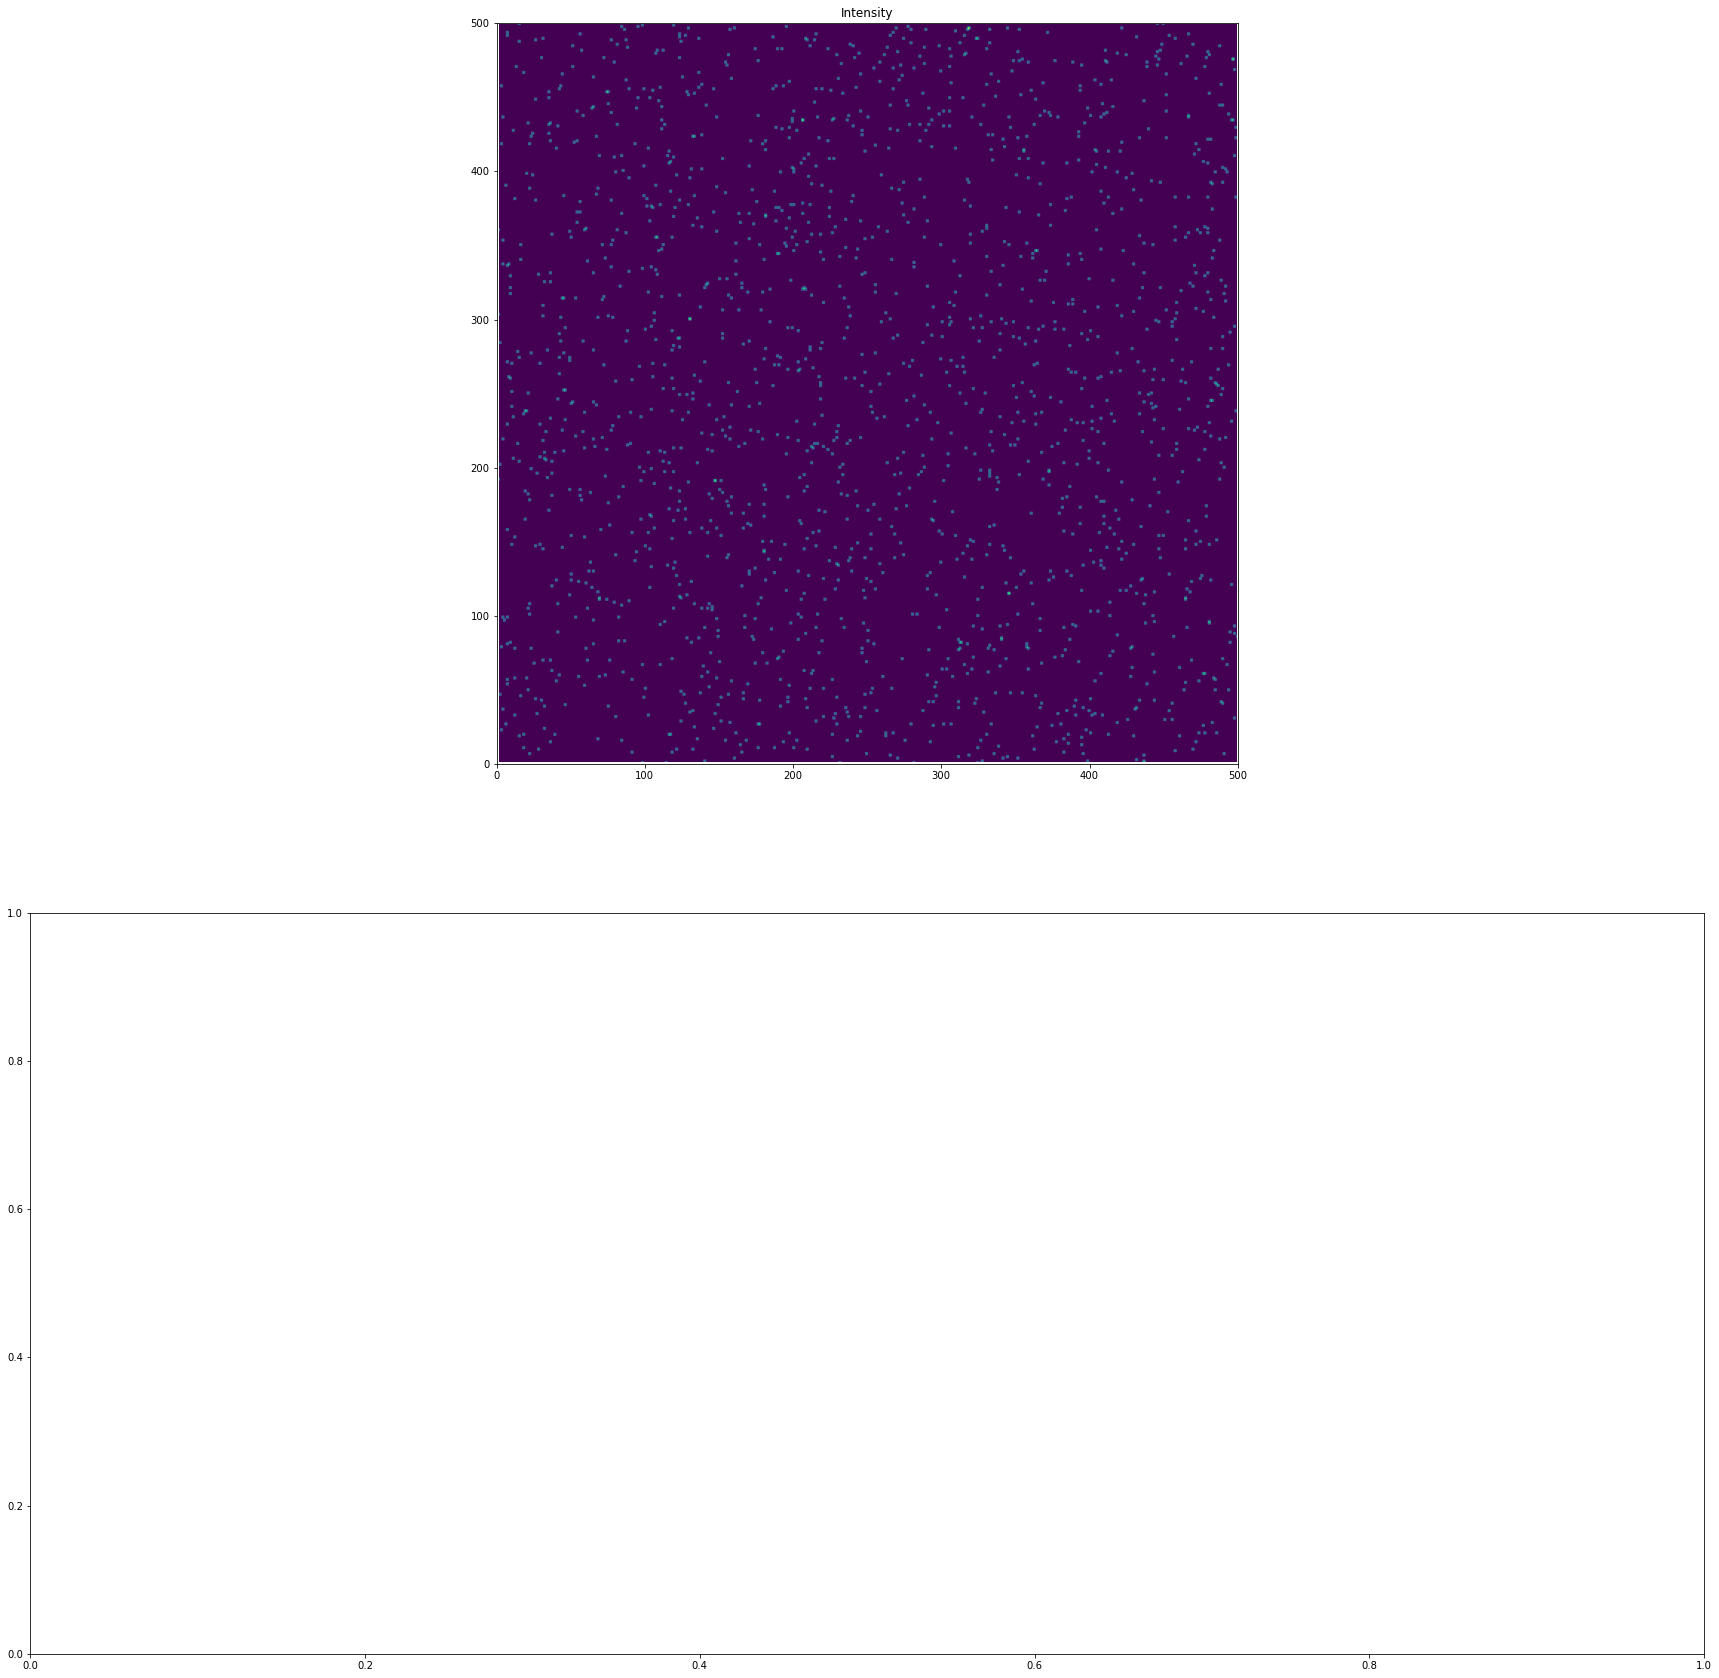

In [23]:
### plt.rcParams['figure.figsize'] = (30, 30)
lv = 0

fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(30, 30)

Xlim = [0+lv,Xmax-lv]
Ylim = [0+lv,Ymax-lv]

ax1.imshow(intensity_ran[:,:,lv], extent=[0,500,0,500])
ax1.title.set_text('Intensity')
ax1.set_xlim(Xlim[0],Xlim[1])
ax1.set_ylim(Ylim[0],Ylim[1])

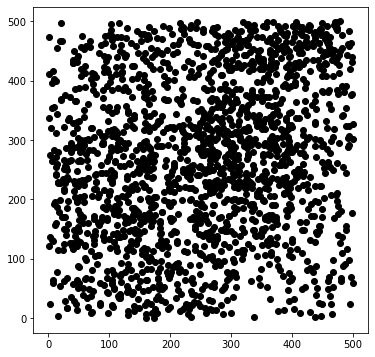

In [11]:
plt.plot(pnt_df['x'], pnt_df['y'], 'o', color='black');

## Export 3D arrays to Matlab files

In [25]:
# ---- save pyramids of clustered points to Matlab files --------------
outpath = "E:/Projects/Pyramid_model/tables/new_point_pattern/" 

fn_i = outpath + "array3D_intensity_ran.mat"
fn_res = outpath + "array3D_residual_ran.mat"
sio.savemat(fn_i, {'vect':intensity_ran})
#sio.savemat(fn_res, {'vect':count_res})